# MLP for the two circles problem

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization

In [5]:
batch_size=128
num_classes=10
epochs=20

In [3]:
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print('Shape-x:\t',xtrain.shape)
print('Shape-y:\t',ytrain.shape)

Shape-x:	 (60000, 28, 28)
Shape-y:	 (60000,)


In [6]:
xtrain=xtrain.reshape(60000,784)
xtest=xtest.reshape(10000,784)
print('Shape-x-train:\t',xtrain.shape)
print('Shape-x-Test:\t',xtest.shape)

Shape-x-train:	 (60000, 784)
Shape-x-Test:	 (10000, 784)


In [7]:
xtrain=xtrain.astype('float32')
xtest=xtest.astype('float32')

In [8]:
xtrain=xtrain/255.
xtest=xtest/255.

In [9]:
print(xtrain.shape[0],'train samples')
print(xtest.shape[0],'test samples')


60000 train samples
10000 test samples


In [10]:
import keras
ytrain=keras.utils.to_categorical(ytrain,num_classes)
ytest=keras.utils.to_categorical(ytest,num_classes)


In [11]:
ytrain.shape

(60000, 10)

In [ ]:
# Sequential Model

In [12]:
model=Sequential()
model.add(Dense(512,activation='relu',input_shape=(784,)))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation='softmax'))
optm=SGD(learning_rate=0.01,momentum=0.9)

model.compile(loss='binary_crossentropy',optimizer=optm,metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 671754 (2.56 MB)
Trainable params: 670730 (2.56 MB)
Non-trainable params: 1024 (4.00 KB)
_________________________________________________________________


In [14]:
history=model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=20,verbose=1)


Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0827 - accuracy: 0.9234 - val_loss: 0.0294 - val_accuracy: 0.9610
Epoch 2/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0274 - accuracy: 0.9647 - val_loss: 0.0215 - val_accuracy: 0.9709
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0196 - accuracy: 0.9763 - val_loss: 0.0181 - val_accuracy: 0.9744
Epoch 4/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0152 - accuracy: 0.9819 - val_loss: 0.0160 - val_accuracy: 0.9775
Epoch 5/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0121 - accuracy: 0.9867 - val_loss: 0.0145 - val_accuracy: 0.9791
Epoch 6/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0101 - accuracy: 0.9891 - val_loss: 0.0139 - val_accuracy: 0.9795
Epoch 7/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0082 - accuracy: 0.9925 - val_loss: 0.0130 -

In [15]:
_,train_acc=model.evaluate(xtrain,ytrain,verbose=1)
_,test_acc=model.evaluate(xtest,ytest,verbose=1)
print('Train Accuracy:\t',train_acc)
print()
print('Test Accuracy:\t',test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0119 - accuracy: 0.9836
Train Accuracy:	 0.9999499917030334

Test Accuracy:	 0.9836000204086304


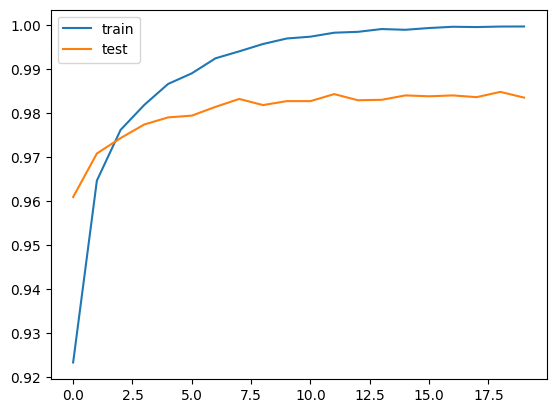

In [16]:
pyplot.plot(history.history['accuracy'],label='train')
pyplot.plot(history.history['val_accuracy'],label='test')
pyplot.legend()
pyplot.show()

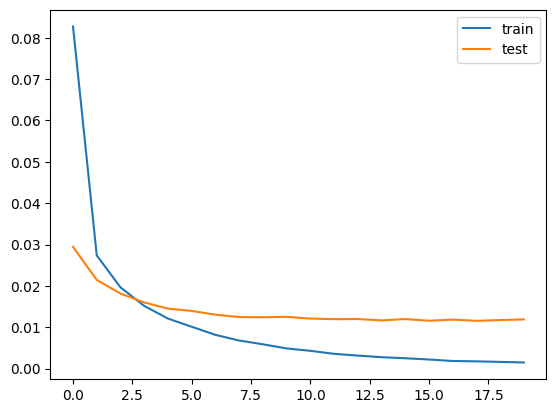

In [17]:
pyplot.plot(history.history['loss'],label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameter

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))

    # Tune the number of hidden layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner and perform hyperparameter tuning
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_dir',
    project_name='mnist_hyperband'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Trial 30 Complete [00h 01m 29s]
val_accuracy: 0.9782000184059143

Best val_accuracy So Far: 0.9793000221252441
Total elapsed time: 00h 20m 31s
Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2910 - accuracy: 0.9147 - val_loss: 0.1402 - val_accuracy: 0.9572
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1440 - accuracy: 0.9556 - val_loss: 0.0971 - val_accuracy: 0.9703
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1059 - accuracy: 0.9679 - val_loss: 0.0867 - val_accuracy: 0.9743
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0897 - accuracy: 0.9714 - val_loss: 0.0768 - val_accuracy: 0.9779
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0747 - accuracy: 0.9769 - val_loss: 0.0738 - val_accuracy: 0.9774
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0665 - accuracy: 0.9781 - val_loss: 0.0701 - val_accuracy:

In [19]:
pip install keras-tuner


  Using cached keras_tuner-1.4.6-py3-none-any.whl (128 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
Note: you may need to restart the kernel to use updated packages.
